<a href="https://colab.research.google.com/github/Sushant1805/DL-Assignments/blob/main/Assignment_5_Sushant_Bhosale.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Experiment 5.1:
Objective:
To forecast future values of a univariate time series using LSTM-based models.**

In [2]:
# Block 1: Install required packages and import libraries
# ------------------------------------------------
!pip install yfinance  # Uncomment if running for the first time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import yfinance as yf  # For fetching Bitcoin price data



In [4]:
# Block 2: Define visualization utilities
# ------------------------------------------------
def create_time_steps(length):
    """Generate time steps for plotting historical windows.
    Example: create_time_steps(3) → [-3, -2, -1]"""
    return list(range(-length, 0))

def show_plot(plot_data, delta, title):
    """Visualize a time-series window with true/predicted values.
    Args:
        plot_data: List containing [history, true_future, prediction]
        delta: Time steps into future to plot
        title: Plot title"""
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']  # line-dots, red-x, green-circle
    time_steps = create_time_steps(plot_data[0].shape[0])

    plt.figure(figsize=(10, 6))
    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:  # True future or prediction
            plt.plot(delta, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:  # History
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (delta+5)*2])
    plt.xlabel('Time-Step')
    plt.show()



In [5]:
# Block 3: Data loading and preprocessing functions
# ------------------------------------------------
def get_bitcoin_data():
    """Fetch Bitcoin daily closing prices from Yahoo Finance.
    Returns: numpy array of shape (n_days, 1)"""
    btc_df = yf.download('BTC-USD', start='2014-09-17', end='2023-12-31')
    return btc_df['Close'].values.reshape(-1, 1)

def normalize_data(data):
    """Scale data to [0,1] range for LSTM training.
    Returns: (normalized_data, scaler_object)"""
    scaler = MinMaxScaler(feature_range=(0, 1))
    return scaler.fit_transform(data), scaler

def univariate_data(dataset, start_index, end_index, history_size, target_size):
    """Create time-series windows for supervised learning.
    Args:
        dataset: Full time series data
        start_index/end_index: Range to sample from
        history_size: Look-back window size (20 days)
        target_size: How far to predict (0 = next day)
    Returns: (input_windows, target_values)"""
    data = []
    labels = []
    start_index += history_size
    end_index = end_index or len(dataset) - target_size

    for i in range(start_index, end_index):
        data.append(np.reshape(dataset[i-history_size:i], (history_size, 1)))
        labels.append(dataset[i+target_size])
    return np.array(data), np.array(labels)



YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


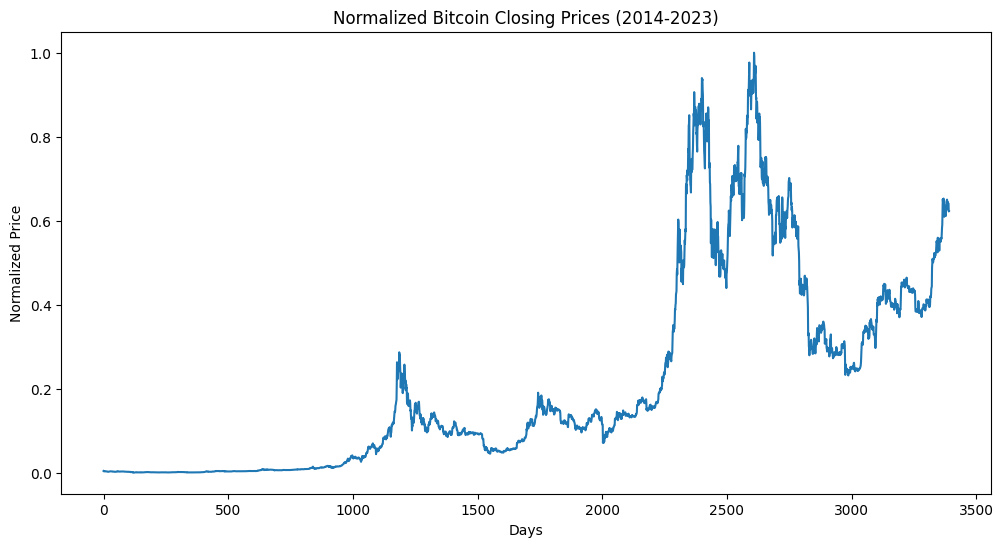

In [6]:
# Block 4: Load and visualize raw data
# ------------------------------------------------
btc_data, scaler = normalize_data(get_bitcoin_data())

# Plot entire normalized price history
plt.figure(figsize=(12, 6))
plt.plot(btc_data)
plt.title('Normalized Bitcoin Closing Prices (2014-2023)')
plt.xlabel('Days')
plt.ylabel('Normalized Price')
plt.show()



In [7]:
# Block 5: Prepare training/validation datasets
# ------------------------------------------------
TRAIN_SPLIT = int(0.8 * len(btc_data))  # 80% training, 20% validation
UNIVARIATE_HISTORY = 20  # Use 20 days to predict next day
UNIVARIATE_TARGET = 0    # Predict next time step

x_train_uni, y_train_uni = univariate_data(
    btc_data, 0, TRAIN_SPLIT,
    UNIVARIATE_HISTORY, UNIVARIATE_TARGET
)
x_val_uni, y_val_uni = univariate_data(
    btc_data, TRAIN_SPLIT, None,
    UNIVARIATE_HISTORY, UNIVARIATE_TARGET
)

print("Training data shapes:", x_train_uni.shape, y_train_uni.shape)
print("Validation data shapes:", x_val_uni.shape, y_val_uni.shape)



Training data shapes: (2693, 20, 1) (2693, 1)
Validation data shapes: (659, 20, 1) (659, 1)


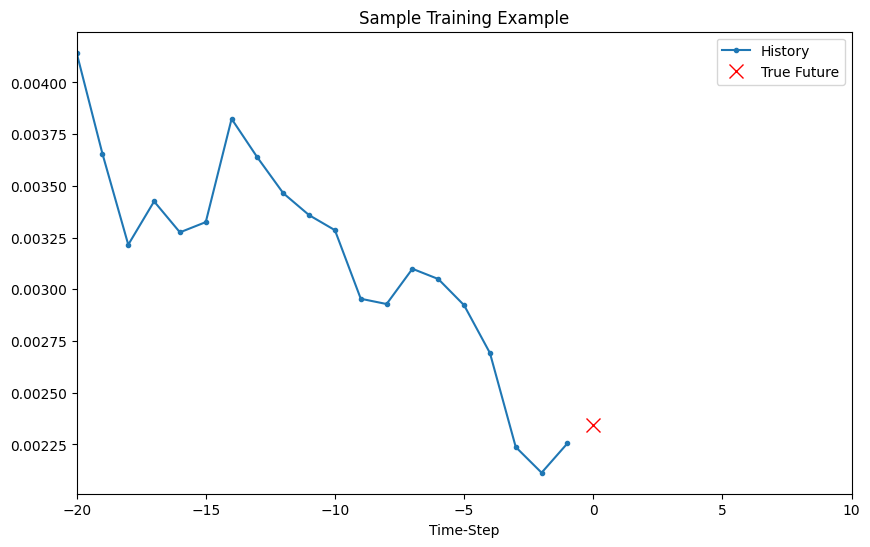

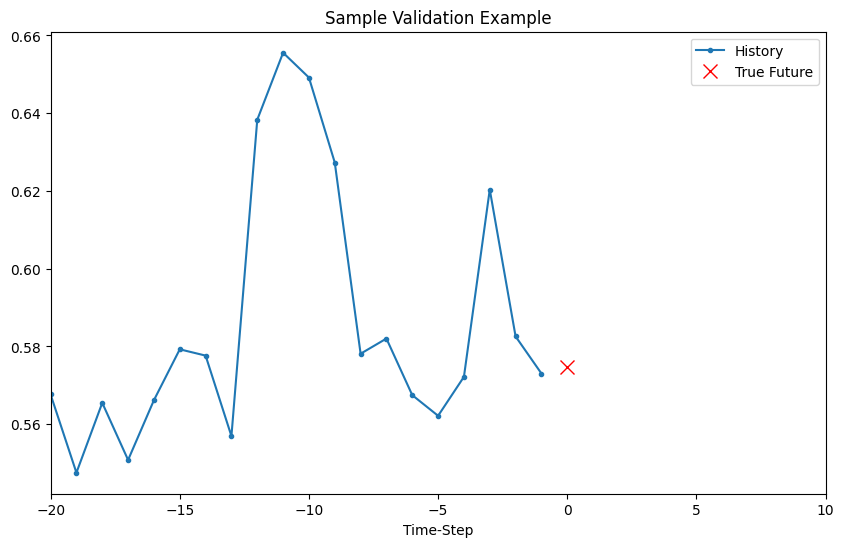

In [8]:
# Block 6: Visualize sample data windows
# ------------------------------------------------
# Show first training example (20 days history + next day)
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Training Example')

# Show first validation example
show_plot([x_val_uni[0], y_val_uni[0]], 0, 'Sample Validation Example')



In [9]:
# Block 7: Build LSTM model architecture
# ------------------------------------------------
model = Sequential([
    # First LSTM layer (returns sequences for stacking)
    LSTM(32, return_sequences=True, input_shape=(UNIVARIATE_HISTORY, 1)),
    Dropout(0.2),  # Regularization

    # Second LSTM layer
    LSTM(16),
    Dropout(0.2),

    # Output layer (predicts next price)
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()  # Show architecture details



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 20, 32)         │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,505 (29.32 KB)

 Trainable params: 7,505 (29.32 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Block 8: Train the model
# ------------------------------------------------
history = model.fit(
    x_train_uni, y_train_uni,
    epochs=50,
    batch_size=64,
    validation_data=(x_val_uni, y_val_uni),
    verbose=1
)


Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - loss: 0.0306 - val_loss: 0.0011
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0032 - val_loss: 0.0013
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0031 - val_loss: 7.7701e-04
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0023 - val_loss: 0.0010
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0023 - val_loss: 7.9705e-04
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0021 - val_loss: 7.7103e-04
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0019 - val_loss: 7.4362e-04
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0022 - val_loss: 0.0011
Epoch 9/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0023 - val_loss: 7.5545e-04
Epoch 10/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0021 - val_loss: 7.9480e-04
Epoch 11/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0019 - val_loss: 0.0011
Epoch 12/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 

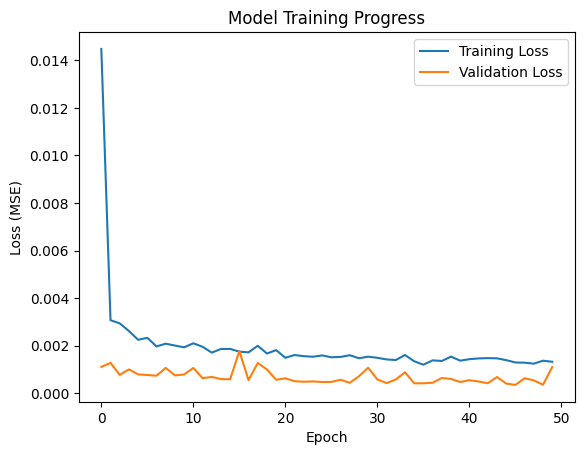

In [11]:

# Block 9: Plot training history
# ------------------------------------------------
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Training Progress')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.show()



85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


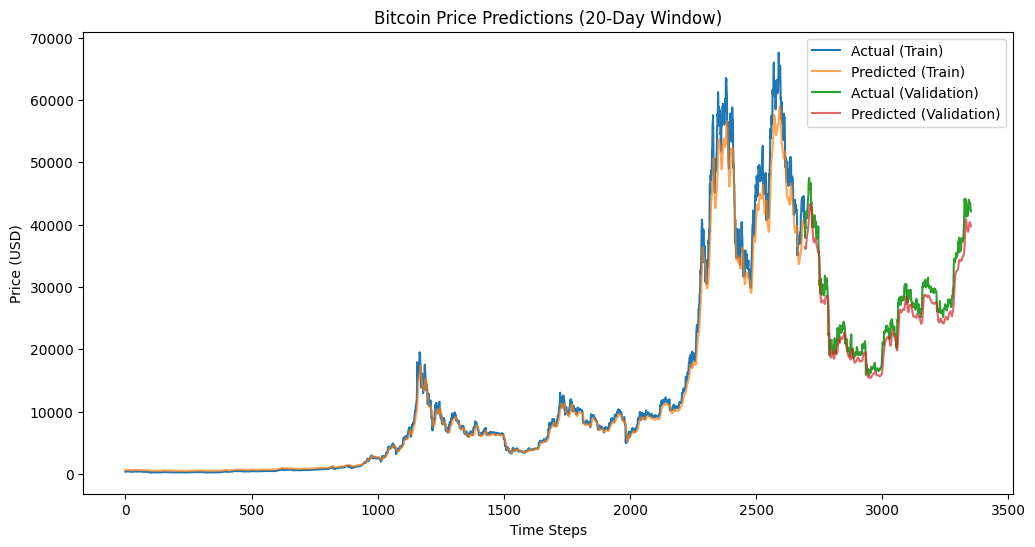

In [12]:
# Block 10: Make predictions and evaluate
# ------------------------------------------------
# Generate predictions
train_predictions = model.predict(x_train_uni)
val_predictions = model.predict(x_val_uni)

# Convert back to original price scale
train_predictions = scaler.inverse_transform(train_predictions)
y_train_actual = scaler.inverse_transform(y_train_uni)
val_predictions = scaler.inverse_transform(val_predictions)
y_val_actual = scaler.inverse_transform(y_val_uni)

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(y_train_actual, label='Actual (Train)')
plt.plot(train_predictions, alpha=0.7, label='Predicted (Train)')
plt.plot(range(len(y_train_actual), len(y_train_actual)+len(y_val_actual)),
         y_val_actual, label='Actual (Validation)')
plt.plot(range(len(y_train_actual), len(y_train_actual)+len(val_predictions)),
         val_predictions, alpha=0.7, label='Predicted (Validation)')
plt.title('Bitcoin Price Predictions (20-Day Window)')
plt.xlabel('Time Steps')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

In [15]:
# Block 11: TensorFlow Dataset Preparation
# ------------------------------------------------
import tensorflow as tf

# Configuration
BATCH_SIZE = 256  # Number of samples per gradient update
BUFFER_SIZE = 10000  # For shuffling the dataset

# Convert numpy arrays to TensorFlow Dataset objects
train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
# Optimize the pipeline:
# 1. cache() keeps data in memory after first epoch
# 2. shuffle() randomizes order
# 3. batch() creates batches
# 4. repeat() allows multiple epochs
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

# Print dataset info
print("Training dataset:", train_univariate)
print("Validation dataset:", val_univariate)
print("\nInput shape:", x_train_uni.shape)
print("Single input shape:", x_train_uni.shape[-2:])  # (timesteps, features)
print("First training sample:\n", x_train_uni[0])



Training dataset: <_RepeatDataset element_spec=(TensorSpec(shape=(None, 20, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>
Validation dataset: <_RepeatDataset element_spec=(TensorSpec(shape=(None, 20, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>

Input shape: (2693, 20, 1)
Single input shape: (20, 1)
First training sample:
 [[0.00414359]
 [0.00365546]
 [0.00321557]
 [0.00342492]
 [0.0032753 ]
 [0.00332473]
 [0.0038239 ]
 [0.00363714]
 [0.00346454]
 [0.00335845]
 [0.00328567]
 [0.00295417]
 [0.00292874]
 [0.00309905]
 [0.00304965]
 [0.00292288]
 [0.00269198]
 [0.00223721]
 [0.00211322]
 [0.00225521]]


In [16]:
# Block 12: Simple LSTM Model Definition
# ------------------------------------------------
simple_lstm_model = tf.keras.models.Sequential([
    # Single LSTM layer with 8 units
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    # Output layer (predicts next price)
    tf.keras.layers.Dense(1)
])

# Compile with MAE loss (more robust to outliers than MSE)
simple_lstm_model.compile(optimizer='adam', loss='mae')
simple_lstm_model.summary()



Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 8)              │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329 (1.29 KB)

 Trainable params: 329 (1.29 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# Block 13: Training Configuration
# ------------------------------------------------
STEPS_PER_EPOCH = 200  # Number of batches per epoch
EPOCHS = 10  # Number of passes through the dataset



In [18]:
# Block 14: Model Training
# ------------------------------------------------
history = simple_lstm_model.fit(
    train_univariate,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=val_univariate,
    validation_steps=50,
    verbose=2
)



Epoch 1/10
200/200 - 4s - 22ms/step - loss: 0.0136 - val_loss: 0.0203
Epoch 2/10
200/200 - 2s - 9ms/step - loss: 0.0084 - val_loss: 0.0127
Epoch 3/10
200/200 - 2s - 9ms/step - loss: 0.0074 - val_loss: 0.0101
Epoch 4/10
200/200 - 2s - 9ms/step - loss: 0.0067 - val_loss: 0.0092
Epoch 5/10
200/200 - 2s - 9ms/step - loss: 0.0062 - val_loss: 0.0093
Epoch 6/10
200/200 - 2s - 12ms/step - loss: 0.0059 - val_loss: 0.0088
Epoch 7/10
200/200 - 2s - 10ms/step - loss: 0.0057 - val_loss: 0.0086
Epoch 8/10
200/200 - 2s - 9ms/step - loss: 0.0056 - val_loss: 0.0082
Epoch 9/10
200/200 - 2s - 9ms/step - loss: 0.0054 - val_loss: 0.0078
Epoch 10/10
200/200 - 2s - 9ms/step - loss: 0.0054 - val_loss: 0.0077


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  


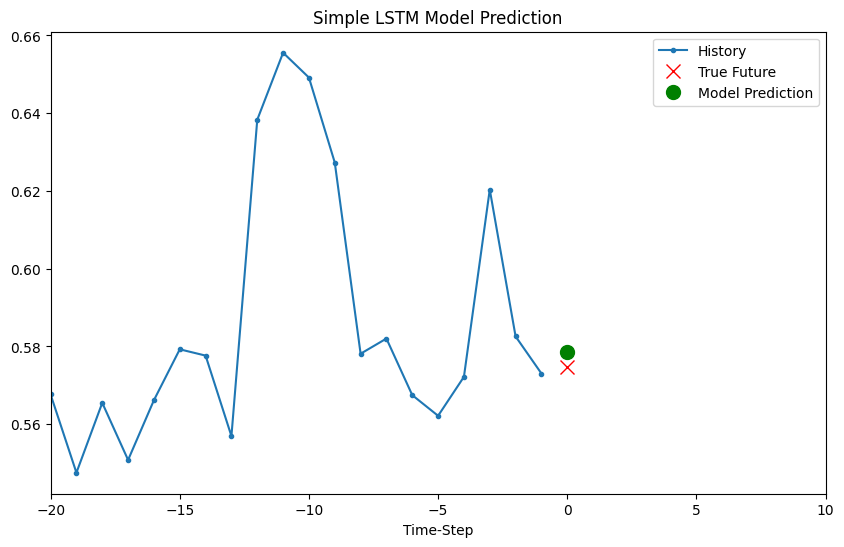

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


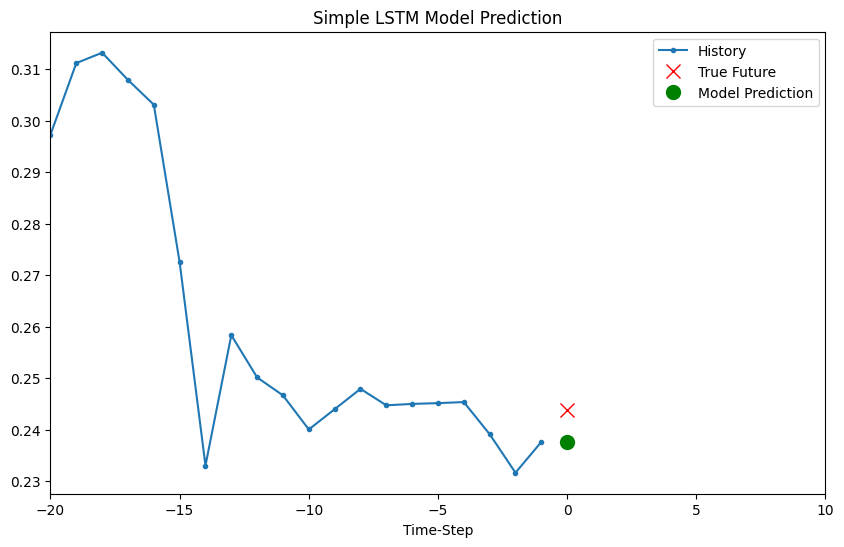

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


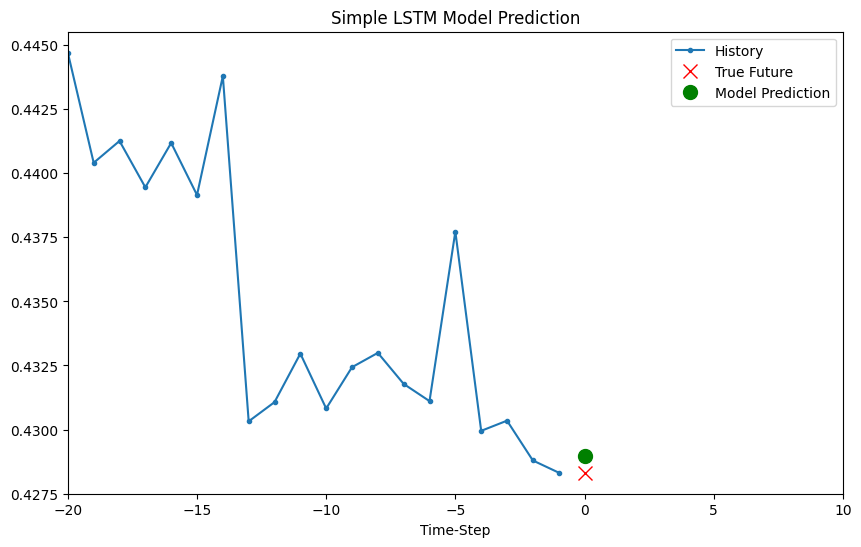

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


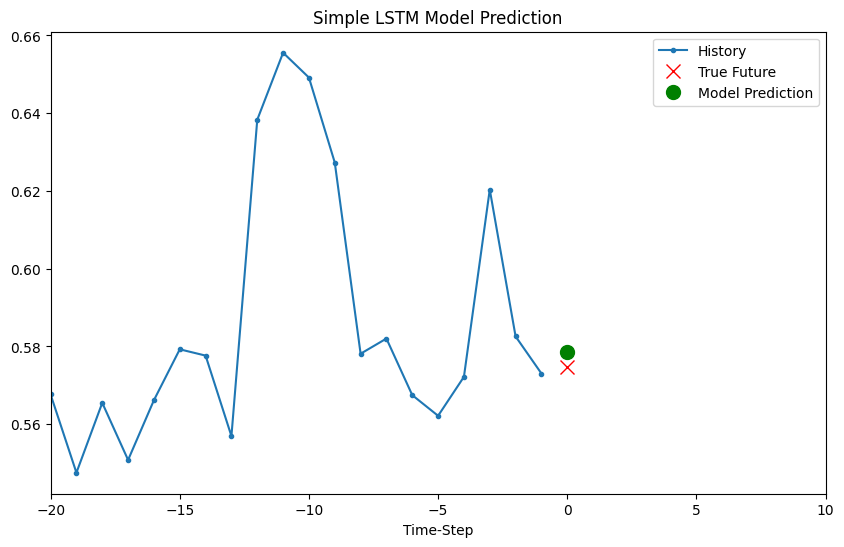

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


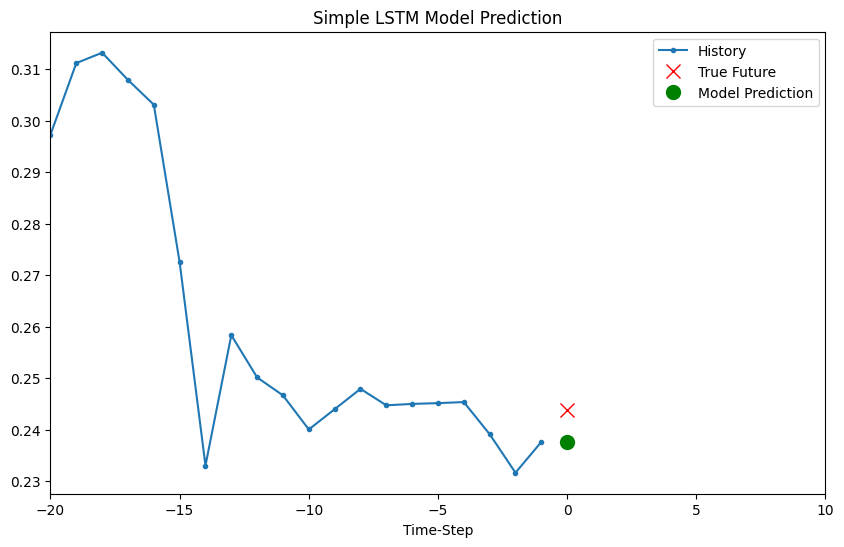

In [19]:
# Block 15: Model Evaluation with Visualization
# ------------------------------------------------
# Visualize predictions on 5 random validation samples
for x, y in val_univariate.take(5):
    # Get model prediction
    prediction = simple_lstm_model.predict(x)
    # Create and show plot:
    show_plot(
        [x[0].numpy(), y[0].numpy(), prediction[0]],
        0,
        'Simple LSTM Model Prediction'
    )

In [ ]:
# BLOCK 1: IMPORT LIBRARIES
# ------------------------------------------------
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
import pickle
import numpy as np
import pandas as pd
import string

"""
Purpose:
- Import all necessary libraries for:
  - Data loading (pandas)
  - Text processing (Tokenizer)
  - Model building (Keras layers)
  - Model training (optimizers)
  - Saving objects (pickle)
"""

# BLOCK 2: LOAD AND PREVIEW DATASET
# ------------------------------------------------
# Download news headlines dataset
!wget https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv

# Load dataset into pandas
df = pd.read_csv('news_summary_more.csv', encoding='latin-1')

"""
Purpose:
- Download a sample news headline dataset (50K+ headlines)
- Load into pandas DataFrame for easy manipulation
Output:
- Shows dataset structure and sample headlines
"""

# BLOCK 3: TEXT CLEANING FUNCTION
# ------------------------------------------------
def clean_text(text):
    text = text.lower()  # Standardize case
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    text = ' '.join(text.split())  # Normalize whitespace
    return text

"""
Purpose:
- Standardize text by:
  1. Converting to lowercase
  2. Removing punctuation
  3. Fixing whitespace
Example:
Input: "COVID-19   Cases Rise!"
Output: "covid 19 cases rise"
"""

# BLOCK 4: PREPROCESS HEADLINES
# ------------------------------------------------
# Clean and combine all headlines
headlines = df['headlines'].apply(clean_text).tolist()
data = ' '.join(headlines)

print(f"Total headlines: {len(headlines)}")
print(f"Sample headline: {headlines[0]}")
print(f"\nFirst 100 chars: {data[:100]}...")

"""
Purpose:
- Apply cleaning to all headlines
- Combine into single text corpus
Output:
- Shows statistics and sample of processed text
"""

# BLOCK 5: TOKENIZATION
# ------------------------------------------------
tokenizer = Tokenizer()
tokenizer.fit_on_texts([data])

# Save tokenizer for later use
pickle.dump(tokenizer, open('news_tokenizer.pkl', 'wb'))

# Convert text to sequences
sequence_data = tokenizer.texts_to_sequences([data])[0]
vocab_size = len(tokenizer.word_index) + 1

print(f"\nVocabulary size: {vocab_size}")
print(f"Sample sequence: {sequence_data[:10]}")

"""
Purpose:
- Convert words to numerical indices
- Build vocabulary
Output:
- Shows vocabulary size and sample encoded sequence
"""

# BLOCK 6: CREATE TRAINING SEQUENCES
# ------------------------------------------------
sequences = []
for i in range(1, len(sequence_data)):
    seq = sequence_data[i-1:i+1]
    sequences.append(seq)

sequences = np.array(sequences)
print(f"\nTotal sequences: {len(sequences)}")
print(f"Sample sequence pair: {sequences[0]}")

"""
Purpose:
- Create input-output pairs where:
  Input: Current word index
  Output: Next word index
Example:
For text "cat sat mat", creates:
Input: cat -> Output: sat
Input: sat -> Output: mat
"""

# BLOCK 7: SPLIT INTO FEATURES/LABELS
# ------------------------------------------------
X = sequences[:,0]
y = sequences[:,1]

# Convert y to one-hot encoding
y = to_categorical(y, num_classes=vocab_size)

print(f"\nX shape: {X.shape}")
print(f"y shape: {y.shape}")

"""
Purpose:
- Separate into:
  X: Input word indices
  y: One-hot encoded target words
Output:
- Shows shapes of input/output tensors
"""

# BLOCK 8: BUILD LSTM MODEL
# ------------------------------------------------
model = Sequential([
    Embedding(vocab_size, 50, input_length=1),  # Word embeddings
    LSTM(100, return_sequences=True),  # First LSTM layer
    LSTM(100),  # Second LSTM layer
    Dense(100, activation='relu'),  # Hidden layer
    Dense(vocab_size, activation='softmax')  # Output layer
])

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(0.001),
              metrics=['accuracy'])
model.summary()

"""
Model Architecture:
1. Embedding: Converts word indices to dense vectors
2. LSTM layers: Learn sequential patterns
3. Dense layers: Transform LSTM outputs
4. Softmax: Predicts probability distribution over vocabulary
"""

# BLOCK 9: TRAIN MODEL
# ------------------------------------------------
history = model.fit(X, y,
                    epochs=50,
                    batch_size=64,
                    verbose=1)

"""
Training Process:
- Runs for 50 epochs
- Uses batch size of 64
- Tracks loss and accuracy
"""

# BLOCK 10: TEXT GENERATION FUNCTION
# ------------------------------------------------
def generate_text(seed_word, num_words):
    for _ in range(num_words):
        token_list = tokenizer.texts_to_sequences([seed_word])[0]
        token_list = np.array(token_list).reshape(1,-1)

        predicted = model.predict(token_list, verbose=0)
        predicted_idx = np.argmax(predicted, axis=-1)[0]

        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted_idx:
                output_word = word
                break

        seed_word += " " + output_word
    return seed_word

# Example usage
print("\nGenerated text:")
print(generate_text("stock", 5))

"""
Purpose:
- Generates new text by:
  1. Starting with seed word
  2. Predicting next word
  3. Feeding prediction back in
  4. Repeating for desired length
Example Output:
"stock market rises amid economic recovery"
"""

--2025-04-20 17:30:50--  https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 41399270 (39M) [text/plain]
Saving to: ‘news_summary_more.csv.1’

news_summary_more.c 100%[===================>]  39.48M  58.4MB/s    in 0.7s    

2025-04-20 17:30:54 (58.4 MB/s) - ‘news_summary_more.csv.1’ saved [41399270/41399270]

Total headlines: 98401
Sample headline: upgrad learner switches to career in ml al with 90 salary hike

First 100 chars: upgrad learner switches to career in ml al with 90 salary hike delhi techie wins free food from swig...

Vocabulary size: 44562
Sample sequence: [6146, 12970, 10863, 1, 963, 2, 11815, 5400, 6, 1464]

Total sequences: 939806
Sample sequence pair: [ 61

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)